# Example 2

This is an example that reproduces Figure 5 from Genkin, M., Engel, T.A., Nat Mach Intell 2, 674–683 (2020). Here we apply the proposed model selection method based on features consistency on synthetic data generated from the double-well potential. The model selection code is adopted to be consistent with the latest paper. For the original version, switch to the github branch "moving_beyond_generalization".

In [1]:
import neuralflow
from neuralflow.feature_complexity.fc_base import FC_tools
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import logging
logging.basicConfig(level=logging.INFO)

## Step 1: Load data and calculate Feature complexities (FC)

In this example, data will be loaded from `npz` files. To generate these files, we used the same double-well ground-truth model as in Example 1 (also see FIG. 3,4,5 in the main text). We trained and validated the model on two data samples `D1` and `D2`. Each data sample contains ~20,000 spikes, and the data was split into two equal non-overlapping parts (`D1=D11+D12`, `D2=D21+D22`), where the first part was used for training and the second - for validation. 

Fitting results were saved in two data files (one for each data sample). Each data file contains the following entries: 

`iter_num`: array of intergers, iteration numbers on which `peqs` were recorded, 

`peqs`: 2D array of fitted peqs (only recorded at iterations specified by `iter_num` array), 

`logliks`: negative training loglikelihoods recorded on each iteration, 

`logliksCV`: negative validated loglikelihoods recorded on each iteration. 

For each data sample, we trained a model for 50,000 iterations. These data files can be straight-forwardly generated by extending the code from Example 1. Here we include the precalculated fitting results since fitting 50,000 iterations may take a long time. This data is the same data as was used in FIG. 3,4,5, but fitting results (peqs) are saved sparsely to keep the data files small. Thus, the generated figures may slightly differ from FIG. 5 in the main text.

1) Specify the ground-truth model. 

2) Load data files with the fitting results and convert them to the dictionaries.

3) Initialize feature complexity class and calculate the ground-truth feature complexity.

In [2]:
grid = neuralflow.GLLgrid(Np = 8, Ne = 256)
gt_model = neuralflow.model.new_model(
    peq_model = {"model": "double_well", "params": {"xmin": 0.6, "xmax": 0.0, "depth": 2}},
    p0_model = None,
    D = 10,
    fr_model = [{"model": "rectified_linear", "params": {"slope": 100, "x_thresh": -1}}],
    grid = grid
)
data1 = dict(np.load('data/Ex2_datasample1.npz',allow_pickle=True))
data2 = dict(np.load('data/Ex2_datasample2.npz',allow_pickle=True))

# This is needed to change the old format into the new format
data1['peq'] = [el[np.newaxis,:] for el in data1['peqs'].T]
data2['peq'] = [el[np.newaxis,:] for el in data2['peqs'].T]
del data1['peqs']
del data2['peqs']

fc = FC_tools(non_equilibrium = False, model = gt_model)
FC_gt = fc.compute_FC()

## Step 2: Define the hyperparameters for feature consistency analysis

Note: in the original 2020 paper we defined divergence as a half some of KL divergences between two distribution, 0.5(KL(p1||p2)+KL(p2||p1)). In the later papers we replaced it with Jensen-Shannon (JS) divergence which is more stable numerically. The two are not the same. Here, for consistency with our later work, we will use JS divergence. This requires us to change the threshold for the optimal model from 0.01 to 0.002.

Here we define the following hyperparameters of our feature consistency method: 

`JS_thres`: Threshold Jason-Shanon divergence that defines a point when two models start to diverge (see Methods in the papers).

`FC_stride`: An integer that determines a slack in features complexities: instead of comparing models with exactly the same feature complexities, we allow some slack in the feature complexities of the two models. Here we compare each model trained on data sample 1 to `2*FC_stride+1` models trained on data sample 2.

`smoothing_kernel` - to smooth JS before thresholding.

In addtion, we define the following hyperparameters:

`JS_thres_late`: Same as `JS_thres`, but with a higher value. This threshold will be used to demonstrate that high KL thresholds lead to disagreement in the selected potentials. 

In [3]:
JS_thres=0.002
FC_stride = 5
smoothing_kernel = 0
JS_thres_late=0.008

## Step 3: Perform feature consistency analysis

1) For the analysis, use `FeatureConsistencyAnalysis` function that returns: Feature complexities array calculated on models in data1, the indices of the models in data1 for each of the feature complexities, feature complexities array calculated on models in data2, the indices of the models in data2 for each of the feature complexities, the array of JS divergencies, the index of the optimal feature complexity in FC1.

2) Determine optimal FC (`FC_opt`), as well as early and late FCs. The late feature complexity is found by thresholding the FC with `FC_thres_late`. The early FC is defined as `FC_opt-4`.

In [4]:
FC1, min_inds1, FC2, min_inds2, JS, FC1_opt_ind = fc.FeatureConsistencyAnalysis(
    data1, data2, JS_thres, FC_stride, smoothing_kernel, 10000
    )
FC_opt = FC1[FC1_opt_ind]
FC_late_ind = np.where(JS > JS_thres_late)[0][0]-1
FC_late = FC1[FC_late_ind]
FC_early_ind = np.where(FC1 > FC_opt-4)[0][0]
FC_early = FC1[FC_early_ind]

## Step 4: Visualise the results

Text(0, 0.5, '$-\\log\\mathcal{L}$')

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


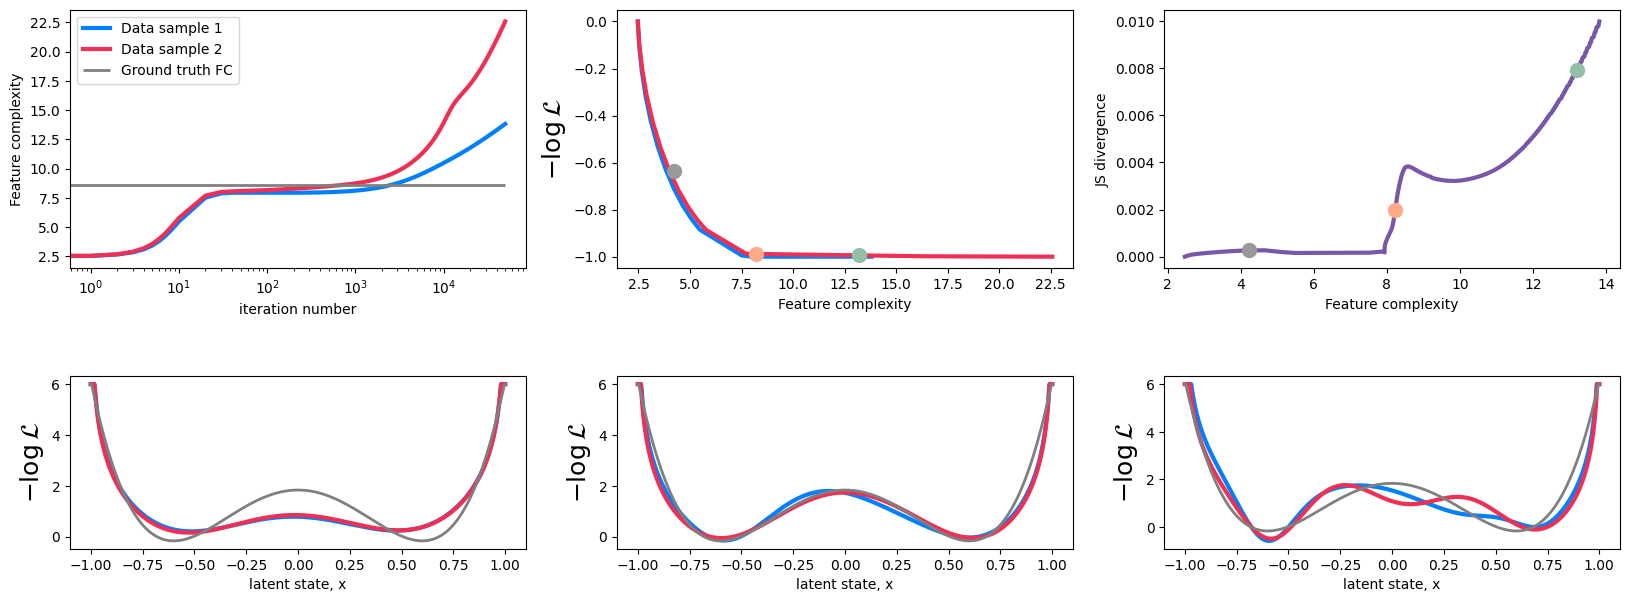

In [5]:
#%%capture
fig=plt.figure(figsize=(20,7))
gs=gridspec.GridSpec(2,3,height_ratios=[3,2],hspace=0.5)
line_colors = [[0, 127/255, 1], [239/255, 48/255, 84/255], [0.5, 0.5, 0.5]]
dot_colors = [[0.6,0.6,0.6], [1, 169/255, 135/255],  [147/255, 192/255, 164/255]]

# Feature complexity vs. iteration number for data sample 1 and data sample 2
ax = plt.subplot(gs[0])
ax.plot(data1['iter_num'], FC1, color=line_colors[0],linewidth=3,label='Data sample 1')
ax.plot(data2['iter_num'], FC2, color=line_colors[1],linewidth=3,label='Data sample 2')
ax.hlines(FC_gt, data1['iter_num'][0],data1['iter_num'][-1],color=line_colors[2],linewidth=2,label='Ground truth FC')
plt.xscale('log')
plt.legend()
plt.xlabel('iteration number')
plt.ylabel('Feature complexity')

# Negative validation loglikelihood vs. feature complexity
ax=plt.subplot(gs[1])
llCV=data1['logliksCV'][data1['iter_num']]
llCV = (llCV-llCV[0])/(np.max(llCV)-np.min(llCV))
ax.plot(FC1, llCV,color=line_colors[0],linewidth=3)
llCV=data2['logliksCV'][data2['iter_num']]
llCV = (llCV-llCV[0])/(np.max(llCV)-np.min(llCV))
ax.plot(FC2, llCV,color=line_colors[1],linewidth=3)
ax.plot(FC_early,llCV[np.argmin(np.abs(FC2-FC_early))],'.',markersize=20,color=dot_colors[0])
ax.plot(FC_opt,llCV[np.argmin(np.abs(FC2-FC_opt))],'.',markersize=20,color=dot_colors[1])
ax.plot(FC_late,llCV[np.argmin(np.abs(FC2-FC_late))],'.',markersize=20,color=dot_colors[2])
plt.xlabel('Feature complexity')
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)

# Feature complexity vs. JS divergence
ax=plt.subplot(gs[2])
ax.plot(FC1, JS, color = [0.47, 0.34, 0.66], linewidth=3)
ax.plot(FC_early, JS[np.argmin(np.abs(FC1 - FC_early))],'.',markersize=20,color=dot_colors[0])
ax.plot(FC_opt, JS[np.argmin(np.abs(FC1 - FC_opt))],'.',markersize=20,color=dot_colors[1])
ax.plot(FC_late, JS[np.argmin(np.abs(FC1 - FC_late))],'.',markersize=20,color=dot_colors[2])
plt.xlabel('Feature complexity')
plt.ylabel('JS divergence')

# The two models and the ground-truth model at FC_early
ax=plt.subplot(gs[3])
ax.plot(grid.x_d,np.minimum(-np.log(data1['peq'][min_inds1[FC_early_ind]][0, :]),6),color=line_colors[0],linewidth=3)
ax.plot(grid.x_d,np.minimum(-np.log(data2['peq'][min_inds2[FC_early_ind]][0, :]),6),color=line_colors[1],linewidth=3)
ax.plot(grid.x_d,np.minimum(-np.log(gt_model.peq[0,:]), 6),color=[0.5, 0.5, 0.5], linewidth=2)
plt.xlabel('latent state, x')
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)

# The two models and the ground-truth model at FC_opt
ax=plt.subplot(gs[4])
ax.plot(grid.x_d,np.minimum(-np.log(data1['peq'][min_inds1[FC1_opt_ind]][0, :]),6),color=line_colors[0],linewidth=3)
ax.plot(grid.x_d,np.minimum(-np.log(data2['peq'][min_inds2[FC1_opt_ind]][0, :]),6),color=line_colors[1],linewidth=3)
ax.plot(grid.x_d,np.minimum(-np.log(gt_model.peq[0,:]),6),color=[0.5, 0.5, 0.5],linewidth=2)
plt.xlabel('latent state, x')
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)

# The two models and the ground-truth model at FC_late
ax=plt.subplot(gs[5])
ax.plot(grid.x_d, np.minimum(-np.log(data1['peq'][min_inds1[FC_late_ind]][0, :]), 6),color=line_colors[0],linewidth=3)
ax.plot(grid.x_d, np.minimum(-np.log(data2['peq'][min_inds2[FC_late_ind]][0, :]), 6),color=line_colors[1],linewidth=3)
ax.plot(grid.x_d, np.minimum(-np.log(gt_model.peq[0,:]),6),color=[0.5, 0.5, 0.5],linewidth=2)
plt.xlabel('latent state, x')
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)